# 使用LSTM模型进行无资料地区径流预报

PUB（Predictions in Ungauged Basins，无资料地区径流预报）是国际水文科学协会在本世纪初提出的第一个十年计划，但即使是目前来看无资料地区仍然缺少可靠的预报方法。水文模型参数区域化方法是目前最常用地无资料地区径流预报方法，但是这要求水文模型的参数具有强烈的物理意义，因为这些参数将通过下垫面的地理信息来确定。而鲜有模型能在预报精度和模型参数的物理意义之间取得平衡，所谓的水文过程机理研究并没有取得突破性进展。基于传统水文模型的研究显然面临着地基不稳的问题。也许直接牺牲模型的物理意义，使用数据驱动的方法来进行无资料地区径流预报是一个可行的方向。这篇blog将复现一篇LSTM模型进行无资料地区径流预报的论文[*Toward Improved Predictions in Ungauged Basins: Exploiting the Power of Machine Learning*](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019WR026065)

In [1]:
# 使用autoreload帮助库的编写
%load_ext autoreload
%autoreload 2
# 使用tensorboard
# %load_ext tensorboard
# %tensorboard --logdir data/EncoderDecoderLSTM/logs
# 设置keras的backend
import os
os.environ["KERAS_BACKEND"] = "jax"

## 1.数据清洗
从CAMELS数据集中加载数据，输入的数据主要分为两部分，一部分是动态时间序列，另一部分是静态地理信息。气象数据包括最高温度、最低温度、降水量、辐射和水汽压力：

| **Variable**            | **Description**                                    |
|-------------------------|----------------------------------------------------|
| Maximum air temp        | 2 m daily maximum air temperature (°C)             |
| Minimum air temp        | 2 m daily minimum air temperature (°C)             |
| Precipitation           | Average daily precipitation (mm/day)               |
| Radiation               | Surface-incident solar radiation (W/m²)            |
| Vapor pressure          | Near-surface daily average (Pa)                    |

我们要对这部分做一个数据清洗，以筛选和构建合适的特征。

### 1.1 数据加载与特征构建

In [2]:
from hydronetwork.data.camels import load_timeseries, get_gauge_id
gauge_id = get_gauge_id(n=1) # 随机选择一个流域
timeseries = load_timeseries(gauge_id="11266500")
timeseries.describe() # 查看数据的描述性统计

timeseries_type,prcp(mm/day),srad(W/m2),tmax(C),tmin(C),vp(Pa),streamflow
count,12784.000000,12784.000000,12784.000000,12784.000000,12784.000000,12784.000000
mean,2.707150,448.233456,10.375909,-0.860192,448.807380,668.619595
std,8.182707,164.298361,8.072034,6.682498,177.150932,1083.057234
min,0.000000,36.810000,-13.660000,-24.240000,92.310000,9.900000
25%,0.000000,319.295000,4.140000,-5.570000,323.235000,57.000000
50%,0.000000,450.320000,10.145000,-1.100000,420.145000,217.000000
75%,0.000000,582.507500,17.312500,4.390000,540.645000,786.000000
max,105.060000,781.400000,29.590000,16.150000,1437.690000,21000.000000


很显然降水和径流都是极度偏态的。也许对数变换是一个不错的选择。再看看分布图。

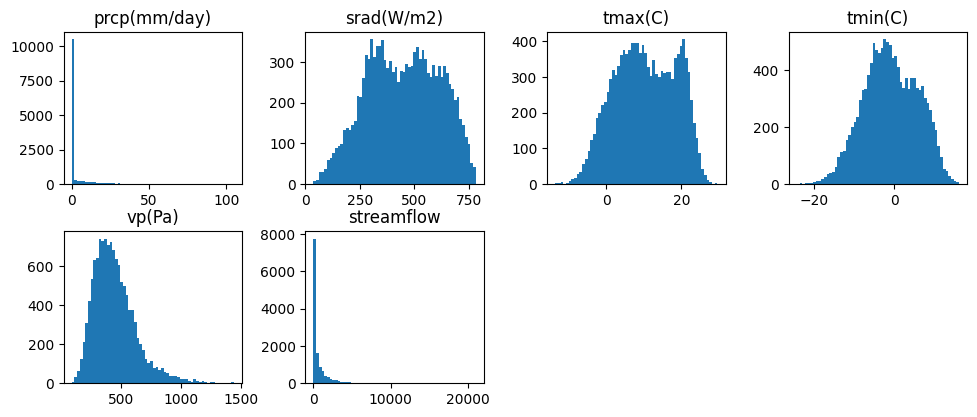

In [3]:
from hydronetwork.plot.matplotlib import hist
fig1, axes1 = hist(timeseries, show=False, ncols=4)

从分布图中可以看出，prcp、vp、streamflow的分布都是偏态的，所以我们对这些数据进行对数变换。

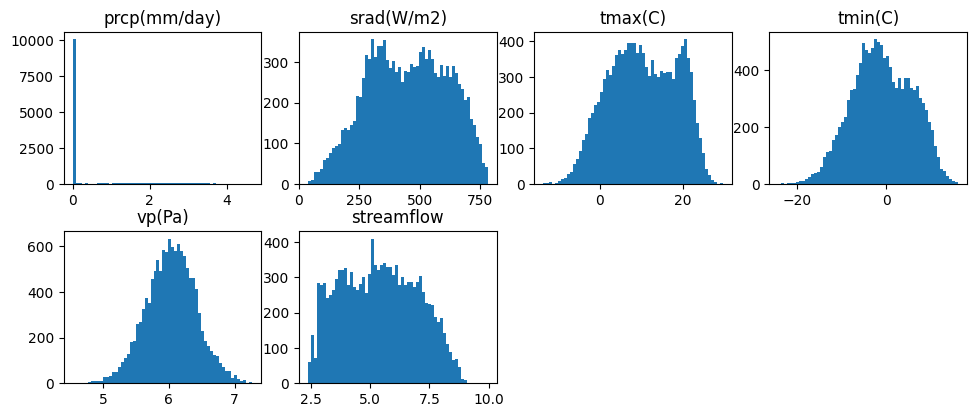

In [6]:
from hydronetwork.dataset.preprocessing import log_transform, log_inverse_transform
timeseries_copy = timeseries.copy()
timeseries_copy['prcp(mm/day)'] = log_transform(timeseries['prcp(mm/day)'])
timeseries_copy['vp(Pa)'] = log_transform(timeseries['vp(Pa)'])
timeseries_copy['streamflow'] = log_transform(timeseries['streamflow'])
fig2, axes2 = hist(timeseries_copy, show=False, ncols=4)

很明显，这里的降水有大量的0值，因此我们增加一个特征，用于表示是否下雨。

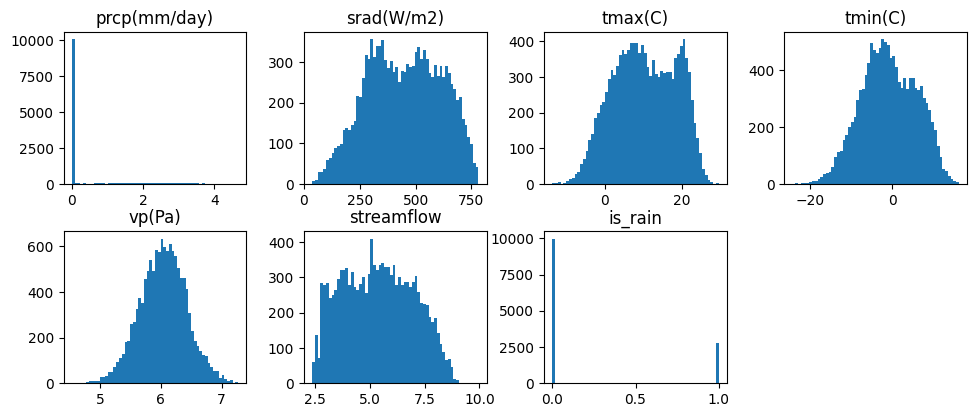

In [7]:
timeseries_copy['is_rain'] = (timeseries_copy['prcp(mm/day)'] > 0).astype(int)
fig3, axes3 = hist(timeseries_copy, show=False, ncols=4)

将数据标准化，使其均值为0，方差为1。

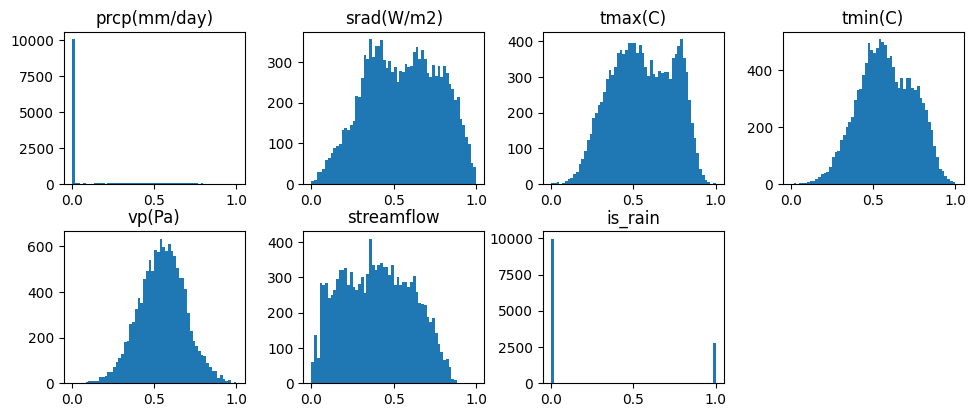

In [10]:
from hydronetwork.dataset.preprocessing import Normalizer
normalizer = Normalizer()
timeseries_copy = normalizer.normalize(timeseries_copy)
normalizer.to_csv("data/EncoderDecoderLSTM/normalizer.csv")
fig4, axes4 = hist(timeseries_copy, show=False, ncols=4)

将数据划分为训练集和测试集并生成数据集

In [15]:
from hydronetwork.dataset.preprocessing import split_timeseries
from hydronetwork.dataset.dataset import get_dataset

train_ts, test_ts = split_timeseries(timeseries_copy, split_list=[0.8, 0.2])
args_get_dataset = {"lookback": 365,
                    "horizon": 7,
                    "features_bidirectional": ["prcp(mm/day)", "srad(W/m2)", "tmax(C)", "tmin(C)", "vp(Pa)", "is_rain"],
                    "target": "streamflow",
                    }
train_dataset = get_dataset(timeseries=train_ts, **args_get_dataset)
test_dataset = get_dataset(timeseries=test_ts, **args_get_dataset)

# 测试一下数据集的输出对不对

In [23]:
# 测试一下数据集的输出对不对
for i, (x, y) in enumerate(train_dataset):
    print(x, y)
    if i == 1:
        break

[[[0.66058937 0.18164359 0.34196532 0.44961624 0.52715769 1.        ]
  [0.48694082 0.33290804 0.4665896  0.43104729 0.50649351 1.        ]
  [0.         0.40007252 0.48924855 0.46001486 0.53671137 0.        ]
  ...
  [0.         0.38062558 0.48647399 0.443179   0.51991706 0.        ]
  [0.         0.40285258 0.50959538 0.43203763 0.50796079 0.        ]
  [0.         0.4089096  0.54150289 0.45357762 0.53207999 0.        ]]

 [[0.48694082 0.33290804 0.4665896  0.43104729 0.50649351 1.        ]
  [0.         0.40007252 0.48924855 0.46001486 0.53671137 0.        ]
  [0.         0.36629555 0.47421965 0.49591483 0.57708071 0.        ]
  ...
  [0.         0.40285258 0.50959538 0.43203763 0.50796079 0.        ]
  [0.         0.4089096  0.54150289 0.45357762 0.53207999 0.        ]
  [0.         0.39366631 0.48971098 0.43525625 0.50926659 0.        ]]

 [[0.         0.40007252 0.48924855 0.46001486 0.53671137 0.        ]
  [0.         0.36629555 0.47421965 0.49591483 0.57708071 0.        ]
  [0

In [47]:
# 测试一下数据集的输出对不对
import numpy as np
for i, (x, y) in enumerate(test_dataset):
    np.set_printoptions(precision=16)
    print(x)
    print(x.shape)
    print(y)
    print(y.shape)
    if i == 0:
        break

[[[0.                 0.4218831840341665 0.4746820809248555
   0.4941817281505322 0.5704598531799819 0.                ]
  [0.                 0.3980445614364953 0.4018497109826589
   0.44466452092102   0.5171667985488971 0.                ]
  [0.                 0.1849608509381002 0.3657803468208092
   0.543946521416192  0.6266647350589314 0.                ]
  ...
  [0.                 0.3148309808082301 0.2783815028901734
   0.3664273334983907 0.4283390564742851 0.                ]
  [0.                 0.3207939940101264 0.3618497109826589
   0.4520921020054469 0.5265087229395848 0.                ]
  [0.2023809804304867 0.2292268228152406 0.4275144508670521
   0.5687051250309482 0.6553860257017097 1.                ]]

 [[0.                 0.3980445614364953 0.4018497109826589
   0.44466452092102   0.5171667985488971 0.                ]
  [0.                 0.1849608509381002 0.3657803468208092
   0.543946521416192  0.6266647350589314 0.                ]
  [0.8524323452536753 0.

## 1.2 特征选择器：Encoder-Decoder LSTM
使用keras实现LSTM模型，理论上来说框架的选择并不会对模型的性能产生影响，但近期的实验似乎表明keras在LSTM模型上的性能要优于pytorch🤔。encoder-decoder LSTM模型是一种特殊的LSTM模型，它的输入和输出都是序列数据。在这个模型中，编码器将输入序列转换为一个固定长度的向量，解码器将这个向量转换为输出序列。这种模型在机器翻译、语音识别等任务中表现出色。在这个任务中，我们将使用encoder-decoder LSTM模型来预测未来7天的径流。

In [129]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras

### 1.2.1 模型与优化器
构建一个keras的encoder-decoder LSTM模型，其中encoder和decoder都是LSTM模型，最后通过一个全连接层将输出转换为径流。

In [130]:
from hydronetwork.model import EncoderDecoderLSTM
from hydronetwork.train import WarmupExponentialDecay
from hydronetwork.metric import nse, rmse

model = EncoderDecoderLSTM(horizon=args_get_dataset["horizon"], lookback=args_get_dataset["lookback"],)
optimizer = keras.optimizers.AdamW(learning_rate=WarmupExponentialDecay(initial_learning_rate=0.0001))
model.compile(optimizer=optimizer, loss=rmse)

在训练时设置一些回调函数，包括：
- EarlyStopping：当验证集的loss不再下降时停止训练
- ModelCheckpoint：保存模型的权重
- BackupAndRestore：保存模型的权重
- ProgbarLogger：显示训练进度
- CSVLogger：将训练过程保存为csv文件
- TerminateOnNaN：当出现NaN时停止训练

In [131]:
from hydronetwork.train import get_call_backs
callbacks = get_call_backs(model=model, patience=10)

### 1.2.2 训练模型

In [132]:
model.fit(train_dataset, validation_data=test_dataset, epochs=200, callbacks=callbacks)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - loss: 0.4592 - val_loss: 0.4068
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step - loss: 0.4255 - val_loss: 0.4068
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - loss: 0.4268 - val_loss: 0.4068
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 344ms/step - loss: 0.4266 - val_loss: 0.4068
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - loss: 0.4263 - val_loss: 0.4068
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - loss: 0.4258 - val_loss: 0.4068
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - loss: 0.4258 - val_loss: 0.4068
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - loss: 0.4284 - val_loss: 0.4068
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - loss: 0.4267 - val_loss: 0.4068
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: 0.4275 - val_loss: 0.4068
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - loss: 0.4286 - val_loss: 0.4068
